# 2) Data Analysis - US Hit Streaming Songs Project

__The following Jupyter Notebook analyzes the data collected in the previous section of this project__. The analysis will be split into the following sections:
- Imports
- Data Distribution Analysis
- Variable Correlation Analysis
- Analysis of Song Length
- Largest album eras of the streaming era on the Top 50
- Largest artists of the streaming era on the Top 50
- Dashboard of week-to-week changes in music qualities
    - ___For some reason, the interactive plotly dashboard at the end of this Notebook doesn't show up when uploading to GitHub. Please view [the other version of this Jupyter Notebook to see the full dashboard](https://tinyurl.com/WeeklyTrendsStreamingHits)!___

# Imports
To start, we import necessary tools and the data collected previously. 

In [1]:
#for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#to remove the limits on a dataframe's columns displayed
pd.set_option('display.max_columns', None)

#to access google sheets with python
import gspread
from google.oauth2 import service_account
from oauth2client.service_account import ServiceAccountCredentials

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

#for plotly
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.express as px
import cufflinks as cf

# For Notebooks (plotly)
init_notebook_mode(connected=True)

# For offline use (plotly)
cf.go_offline()

In [2]:
#service account
sa = gspread.service_account(filename="gspread_service_account.json")

#sheet
sh = sa.open("HITS Streaming Songs")

#worksheet
wks = sh.worksheet("DF to Gspread")

#uses all values in the worksheet for the data frame
gsheets_df_updated = pd.DataFrame(wks.get_all_values())

header = gsheets_df_updated.iloc[0] #isolate first row as header
gsheets_df_updated = gsheets_df_updated[1:] #get rid of header in original df
gsheets_df_updated.columns = header

#set 'index' as index
gsheets_df_updated = gsheets_df_updated.set_index('index')

#convert index from string to int
gsheets_df_updated.index = gsheets_df_updated.index.astype(int)

#fill in blank values with 0 
gsheets_df_updated = gsheets_df_updated.replace(r'^\s*$', "0", regex=True)
    
#turn peak_date strings to date format
gsheets_df_updated['peak_date'] = pd.to_datetime(gsheets_df_updated['peak_date'])
gsheets_df_updated['release_date'] = pd.to_datetime(gsheets_df_updated['release_date'])

#change the following columns to int/float/boolean format
gsheets_df_updated.loc[:,'streams_2017_to_present':'holiday_music'] = gsheets_df_updated.loc[:,'streams_2017_to_present':'holiday_music'].astype(int)
gsheets_df_updated.loc[:,'length':'valence'] = gsheets_df_updated.loc[:,'length':'valence'].astype(float)
gsheets_df_updated['explicit'] = gsheets_df_updated['explicit'].apply(eval)

#drop christmas songs
gsheets_df_updated.drop(gsheets_df_updated[gsheets_df_updated['holiday_music']==1].index,inplace=True)
gsheets_df_updated.reset_index(drop=True, inplace=True)

gsheets_df_updated

,title,artist,album,peak_date,streams_2017_to_present,total_streams_2020s,peak_week_streams,current_year,2022-10-07,2022-09-30,2022-09-23,2022-09-16,2022-09-09,2022-09-02,2022-08-26,2022-08-19,2022-08-12,2022-08-05,2022-07-29,2022-07-22,2022-07-15,2022-07-08,2022-07-01,2022-06-24,2022-06-17,2022-06-10,2022-06-03,2022-05-27,2022-05-20,2022-05-13,2022-05-06,2022-04-29,2022-04-22,2022-04-15,2022-04-08,2022-04-01,2022-03-25,2022-03-18,2022-03-11,2022-03-04,2022-02-25,2022-02-18,2022-02-11,2022-02-04,2022-01-28,2022-01-21,2022-01-14,2022-01-07,2021-12-31,2021-12-24,2021-12-17,2021-12-10,2021-12-03,2021-11-26,2021-11-19,2021-11-12,2021-11-05,2021-10-29,2021-10-22,2021-10-15,2021-10-08,2021-10-01,2021-09-24,2021-09-17,2021-09-10,2021-09-03,2021-08-27,2021-08-20,2021-08-13,2021-08-06,2021-07-30,2021-07-23,2021-07-16,2021-07-09,2021-07-02,2021-06-25,2021-06-18,2021-06-11,2021-06-04,2021-05-28,2021-05-21,2021-05-14,2021-05-07,2021-04-30,2021-04-23,2021-04-16,2021-04-09,2021-04-02,2021-03-26,2021-03-19,2021-03-12,2021-03-05,2021-02-26,2021-02-19,2021-02-12,2021-02-05,2021-01-29,2021-01-22,2021-01-15,2021-01-08,2021-01-01,2020-12-25,2020-12-18,2020-12-11,2020-12-04,2020-11-27,2020-11-20,2020-11-13,2020-11-06,2020-10-30,2020-10-23,2020-10-16,2020-10-09,2020-10-02,2020-09-25,2020-09-18,2020-09-11,2020-09-04,2020-08-28,2020-08-21,2020-08-14,2020-08-07,2020-07-31,2020-07-24,2020-07-17,2020-07-10,2020-07-03,2020-06-26,2020-06-19,2020-06-12,2020-06-05,2020-05-29,2020-05-22,2020-05-15,2020-05-08,2020-05-01,2020-04-24,2020-04-17,2020-04-10,2020-04-03,2020-03-27,2020-03-20,2020-03-13,2020-03-06,2020-02-28,2020-02-21,2020-02-14,2020-02-07,2020-01-31,2020-01-24,2020-01-17,2020-01-10,2020-01-03,2019-12-27,2019-12-20,2019-12-13,2019-12-06,2019-11-29,2019-11-22,2019-11-15,2019-11-08,2019-11-01,2019-10-25,2019-10-18,2019-10-11,2019-10-04,2019-09-27,2019-09-20,2019-09-13,2019-09-06,2019-08-30,2019-08-23,2019-08-16,2019-08-09,2019-08-02,2019-07-26,2019-07-19,2019-07-12,2019-07-05,2019-06-28,2019-06-21,2019-06-14,2019-06-07,2019-05-31,2019-05-24,2019-05-17,2019-05-10,2019-05-03,2019-04-26,2019-04-19,2019-04-12,2019-04-05,2019-03-29,2019-03-22,2019-03-15,2019-03-08,2019-03-01,2019-02-22,2019-02-15,2019-02-08,2019-02-01,2019-01-25,2019-01-18,2019-01-11,2019-01-04,2018-12-28,2018-12-21,2018-12-14,2018-12-07,2018-11-30,2018-11-23,2018-11-16,2018-11-09,2018-11-02,2018-10-26,2018-10-19,2018-10-12,2018-10-05,2018-09-28,2018-09-21,2018-09-14,2018-09-07,2018-08-31,2018-08-24,2018-08-17,2018-08-10,2018-08-03,2018-07-27,2018-07-20,2018-07-13,2018-07-06,2018-06-29,2018-06-22,2018-06-15,2018-06-08,2018-06-01,2018-05-25,2018-05-18,2018-05-11,2018-05-04,2018-04-27,2018-04-20,2018-04-13,2018-04-06,2018-03-30,2018-03-23,2018-03-16,2018-03-09,2018-03-02,2018-02-23,2018-02-16,2018-02-09,2018-02-02,2018-01-26,2018-01-19,2018-01-12,2018-01-05,2017-12-29,2017-12-15,2017-12-08,2017-12-01,2017-11-24,2017-11-17,2017-11-10,2017-11-03,2017-10-27,2017-10-20,2017-10-13,2017-10-06,2017-09-29,2017-09-22,2017-09-15,2017-09-08,2017-09-01,2017-08-25,2017-08-18,2017-08-11,2017-08-04,2017-07-28,2017-07-21,2017-07-14,2017-07-07,2017-06-30,2017-06-23,2017-06-16,2017-06-09,2017-06-02,2017-05-26,2017-05-19,2017-05-12,2017-05-05,2017-04-28,2017-04-21,2017-04-14,2017-04-07,2017-03-31,total_2022,total_2021,total_2020,total_2019,total_2018,total_2017,units,holiday_music,remix_version,playlist_index,uri,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,explicit
0,Closer,The Chainsmokers,Closer,2016-09-09,10948414,0,5528407,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

# Data distrubution
Based on the following histographs taken from HITS and Spotify, _the following can be concluded_:
 
* A very __small amount of songs reach high popularity levels__ (based on the distributions of streams_2017_to_present and total_streams_2020s)
* Many songs on the top 50 __tend to peak with at a bit less than 10 million weekly streams__
* The __mean length__ of hit songs in the top 50 of streaming are at __around 200,000 milliseconds (or around 3 minutes, 20 seconds)__
* Most top 50 hit songs on streaming __lack acousticness__
* Most top 50 hit songs on streaming lean towards being __more danceable__ than not
* Most top 50 hit songs on streaming lean towards being __more energetic__
* An extremely high amount of songs __lack instrumentalness__
* Most top 50 hit songs on streaming lean towards being __less likely to be recorded with a live audience__
* Hit songs lean to be __more louder__
* The split between songs written in a major key (mode=1) versus a minor key (mode=0) leans __more__ towards __songs written in major key__
* Many songs __lack speechiness__ (_surprising given the prevalence of rap during the streaming era, but this could also make sense because of the rise of emo/melodic rap since 2017_)
* Distribution of __tempos are all over the place__
* The mean valence (musical positiveness conveyed by a track) for all songs leans more towards __sounding slightly more negative (sad, depressed, angry) than happy__

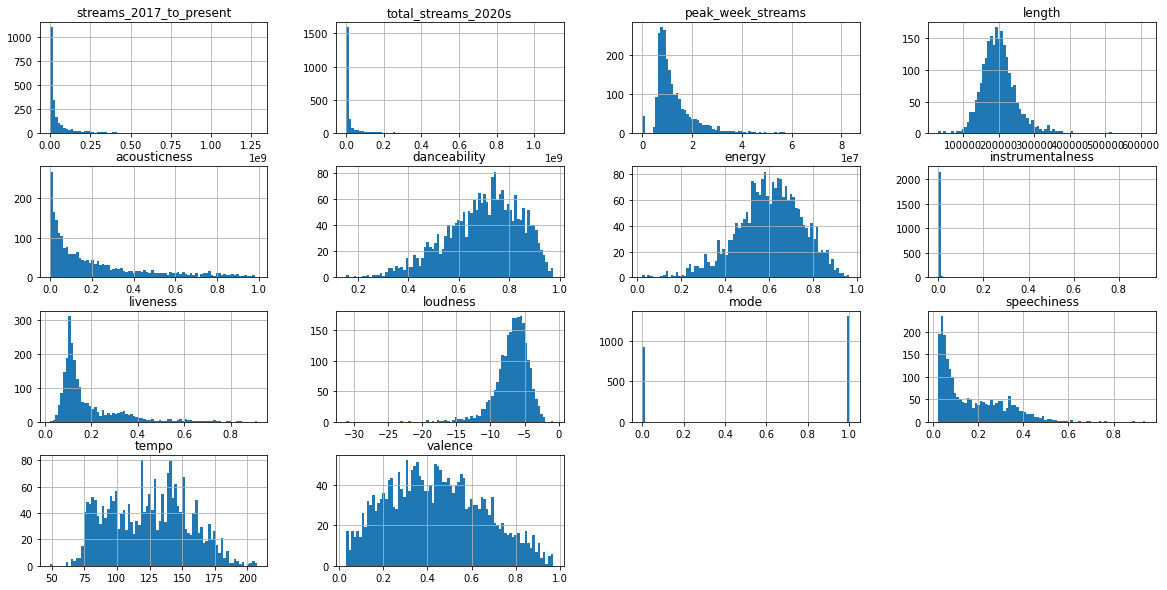

In [3]:
gsheets_df_updated[['streams_2017_to_present','total_streams_2020s'
          ,'peak_week_streams','length','acousticness'
         ,'danceability','energy','instrumentalness','liveness'
         ,'loudness','mode','speechiness','tempo'
          ,'valence']].hist(figsize=(20,10), bins=80)

plt.show()

In [4]:
gsheets_df_updated[['streams_2017_to_present','total_streams_2020s'
          ,'peak_week_streams','length','acousticness'
         ,'danceability','energy','instrumentalness','liveness'
         ,'loudness','mode','speechiness','tempo'
          ,'valence']].describe()

,streams_2017_to_present,total_streams_2020s,peak_week_streams,length,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence
count,2.251000e+03,2.251000e+03,2.251000e+03,2251.000000,2251.000000,2251.000000,2251.000000,2251.000000,2251.000000,2251.000000,2251.000000,2251.000000,2251.000000,2251.000000
mean,6.330712e+07,3.212652e+07,1.293050e+07,201275.433585,0.218442,0.695220,0.601804,0.008819,0.179006,-6.794920,0.584629,0.170623,124.205273,0.440721
std,1.166835e+08,8.562486e+07,8.221781e+06,51137.367359,0.239715,0.146291,0.149102,0.063466,0.129004,2.395604,0.492895,0.137360,30.226116,0.213746
min,0.000000e+00,0.000000e+00,0.000000e+00,30582.000000,0.000070,0.153000,0.021800,0.000000,0.021500,-31.160000,0.000000,0.023200,48.718000,0.032000
25%,8.739177e+06,0.000000e+00,7.875930e+06,169913.000000,0.036200,0.600000,0.513000,0.000000,0.102500,-7.928500,0.000000,0.053650,97.990000,0.274000
50%,1.676568e+07,7.079800e+06,1.036218e+07,196746.000000,0.125000,0.712000,0.610000,0.000000,0.127000,-6.466000,1.000000,0.120000,125.049000,0.433000
75%,5.893532e+07,1.784030e+07,1.536311e+07,225229.500000,0.316500,0.804000,0.706000,0.000012,0.209500,-5.219000,1.000000,0.271000,146.042000,0.592500
max,1.286717e+09,1.100315e+09,8.319680e+07,613026.000000,0.991000,0.974000,0.965000,0.918000,0.914000,-0.804000,1.000000,0.941000,207.476000,0.970000


# Correlation Graph

Based on the graph below, it seems like __only energy and loudness have a strong (below negative 0.67 or above positive 0.67) correlation with each other__.

Text(0.5, 1.0, 'Correlation Graph')

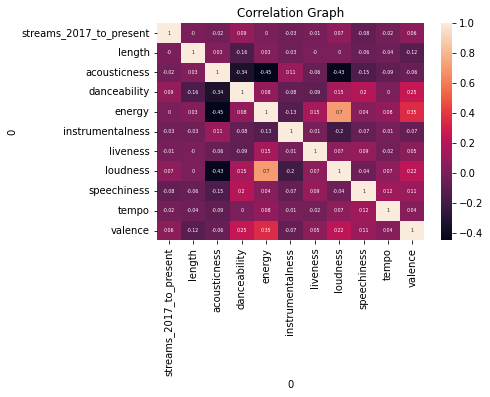

In [5]:
sns.heatmap(gsheets_df_updated.loc[:,['title','artist','album','streams_2017_to_present',
    'length','acousticness','danceability','energy','instrumentalness',
    'liveness','loudness','speechiness','tempo','valence']].corr().round(2),
           annot=True,
           annot_kws={'size': 4.8},
           xticklabels=True, 
           yticklabels=True)
plt.title('Correlation Graph')

# Analysis of Song Length

Prior scholarly research concludes that hit songs are shorter than they were in the past. __The following analyzes whether there are any changes in the mean and median length of a hit song as a song has more streams__. Based on the __visual analysis__ below, __more streams does not necessarily mean shorter song length__. 

In [6]:
#function to convert song length from milliseconds to minutes : seconds : milliseconds format
def ms_to_time(ms):
    """
    Converts milliseconds to time in "minute:secconds:millisecond" format

    Parameters:
        milliseconds (str): the length of a song in milliseconds
    
    Returns
        song_length (str): the length of a song converted into min:sec:ms format 
    """
    millis = ms
    seconds=(millis/1000)%60
    seconds = int(seconds)
    minutes=(millis/(1000*60))%60
    minutes = int(minutes)
    
    #a string will be returned so add 0 before songs with length < 10 mins so that songs above 10 mins won't be misordered when ordering by min:sec:ms format
    if minutes < 10:
        return "0%d:%d:%d" % (minutes, seconds, millis)
    else:
        return "%d:%d:%d" % (minutes, seconds, millis)

The average length of a hit song on the Streaming Top 50 (excluding holiday music) is:  03:21:201275
The median length of a hit song on the Streaming Top 50 (excluding holiday music) is:  03:16:196746
2251 songs appeared on the HITS Streaming Chart since 2017


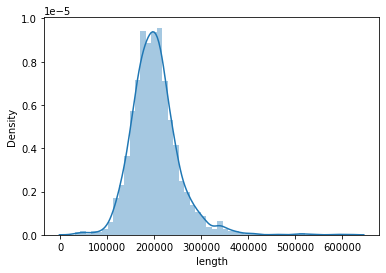

In [7]:
sns.distplot(gsheets_df_updated['length'])

print("The average length of a hit song on the Streaming Top 50 (excluding holiday music) is: ", ms_to_time( int(round(gsheets_df_updated['length'].mean())) ))
print("The median length of a hit song on the Streaming Top 50 (excluding holiday music) is: ", ms_to_time( int(round(gsheets_df_updated['length'].median())) ))
print(len(gsheets_df_updated), "songs appeared on the HITS Streaming Chart since 2017")


The average length of a hit song with at least 50 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:22:202160
The median length of a hit song with at least 50 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:19:199723
625 songs earned over 50 mil streams during their time in the top 50 of Streaming since 2017


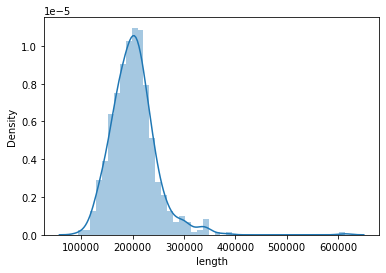

In [8]:
sns.distplot(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 50000000]['length'])

print("The average length of a hit song with at least 50 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 50000000]['length'].mean())) ))
print("The median length of a hit song with at least 50 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 50000000]['length'].median())) ))
print(len(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 50000000]), "songs earned over 50 mil streams during their time in the top 50 of Streaming since 2017")



The average length of a hit song with at least 100 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:21:201835
The median length of a hit song with at least 100 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:20:200944
384 songs earned over 100 mil streams during their time in the top 50 of Streaming since 2017


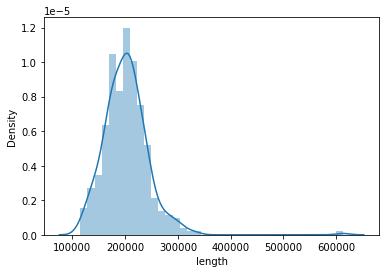

In [9]:
sns.distplot(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 100000000]['length'])

print("The average length of a hit song with at least 100 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 100000000]['length'].mean())) ))
print("The median length of a hit song with at least 100 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 100000000]['length'].median())) ))
print(len(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 100000000]), "songs earned over 100 mil streams during their time in the top 50 of Streaming since 2017")


The average length of a hit song with at least 200 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:18:198575
The median length of a hit song with at least 200 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:16:196077
201 songs earned over 200 mil streams during their time in the top 50 of Streaming since 2017


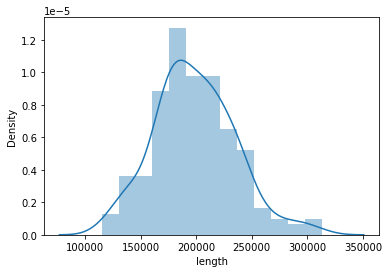

In [10]:
sns.distplot(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 200000000]['length'])

print("The average length of a hit song with at least 200 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 200000000]['length'].mean())) ))
print("The median length of a hit song with at least 200 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 200000000]['length'].median())) ))
print(len(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 200000000]), "songs earned over 200 mil streams during their time in the top 50 of Streaming since 2017")


The average length of a hit song with at least 300 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:20:200051
The median length of a hit song with at least 300 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:19:199506
114 songs earned over 300 mil streams during their time in the top 50 of Streaming since 2017


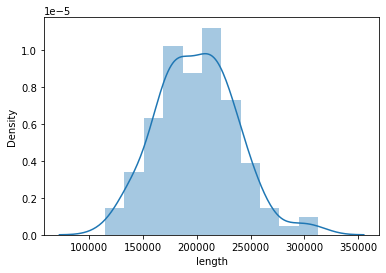

In [11]:
sns.distplot(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 300000000]['length'])

print("The average length of a hit song with at least 300 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 300000000]['length'].mean())) ))
print("The median length of a hit song with at least 300 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 300000000]['length'].median())) ))
print(len(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 300000000]), "songs earned over 300 mil streams during their time in the top 50 of Streaming since 2017")



The average length of a hit song with at least 400 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:16:196045
The median length of a hit song with at least 400 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:16:196040
60 songs earned over 400 mil streams during their time in the top 50 of Streaming since 2017


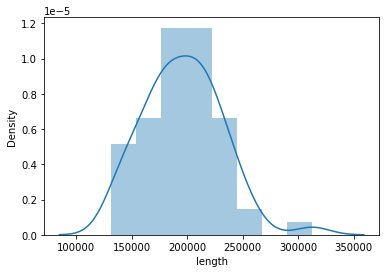

In [12]:
sns.distplot(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 400000000]['length'])

print("The average length of a hit song with at least 400 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 400000000]['length'].mean())) ))
print("The median length of a hit song with at least 400 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 400000000]['length'].median())) ))
print(len(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 400000000]), "songs earned over 400 mil streams during their time in the top 50 of Streaming since 2017")


The average length of a hit song with at least 500 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:18:198313
The median length of a hit song with at least 500 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:19:199506
38 songs earned over 500 mil streams during their time in the top 50 of Streaming since 2017


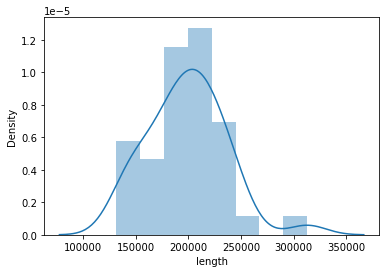

In [13]:
sns.distplot(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 500000000]['length'])

print("The average length of a hit song with at least 500 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 500000000]['length'].mean())) ))
print("The median length of a hit song with at least 500 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 500000000]['length'].median())) ))
print(len(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 500000000]), "songs earned over 500 mil streams during their time in the top 50 of Streaming since 2017")



The average length of a hit song with at least 600 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:24:204580
The median length of a hit song with at least 600 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:20:200040
17 songs earned over 600 mil streams during their time in the top 50 of Streaming since 2017


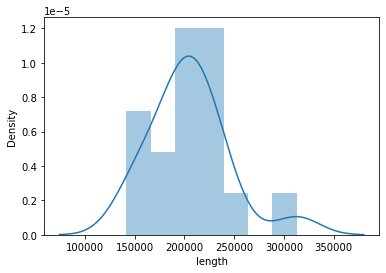

In [14]:
sns.distplot(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 600000000]['length'])

print("The average length of a hit song with at least 600 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 600000000]['length'].mean())) ))
print("The median length of a hit song with at least 600 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 600000000]['length'].median())) ))
print(len(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 600000000]), "songs earned over 600 mil streams during their time in the top 50 of Streaming since 2017")



# Biggest album eras of the on-demand audio streaming era!
__Congrats to the following albums for having the most impact on the top 50!!! 🥳🥳__

In [15]:
gsheets_df_updated.groupby(['album','artist']).sum().sort_values('streams_2017_to_present',ascending=False).head(25).loc[:,['streams_2017_to_present']]



,,streams_2017_to_present
album,artist,
Hollywood's Bleeding,Post Malone,3529505496
Scorpion,Drake,3438508643
beerbongs & bentleys,Post Malone,2881289563
SOUR,Olivia Rodrigo,2314943123
After Hours,The Weeknd,2243048221
Un Verano Sin Ti,Bad Bunny,2212093414
Certified Lover Boy,Drake,1872071124
Shoot For The Stars Aim For The Moon,Pop Smoke,1720816058
DAMN.,Kendrick Lamar,1610093270


# Biggest artists of the on-demand audio streaming era!
__Congrats to the following artists for having the most impact on the top 50 and for being streaming monsters!!! 🥳🥳🫡__

In [16]:
gsheets_df_updated.groupby(['artist']).sum().sort_values('streams_2017_to_present',ascending=False).head(25).loc[:,['streams_2017_to_present']]


,streams_2017_to_present
artist,
Drake,8452787110
Post Malone,7692858523
Lil Baby,3423277111
Juice WRLD,3073253578
Bad Bunny,3008656229
The Weeknd,2994481765
Ariana Grande,2794145950
Lil Nas X,2658461979
Cardi B,2583215792


# Creating a Dashboard of week-to-week changes in song characteristics
Before creating a dashboard, the dataframe must be "melted" (all weekly streams must be condensed into one column). Furthermore, variables (such as tempos and song lengths) must be normalized.

In [17]:
#create a list of dates
list_of_dates = gsheets_df_updated.columns.to_list()[8:-27]

#melt the data (converting the dataframe's info on song streams from horizontal to vertical form)
df_melted = gsheets_df_updated.melt(id_vars=['title','artist','album','peak_date'],
        value_vars=list_of_dates, var_name='observed_date', value_name='streams')
df_melted.drop(df_melted[df_melted['streams']==0].index, inplace=True) #drop all weekly observations with 0 streams
df_melted.reset_index(drop=True, inplace=True)

#convert the observed_date to a datetime format
df_melted['observed_date'] = pd.to_datetime(df_melted['observed_date'])

#drop data from the weeks starting on 2019-12-13 and 2019-12-20
#there's very few data on those weeks (these few songs were individually-calculated using Rolling Stones charts as reference)
df_melted.drop(df_melted[ (df_melted['observed_date']=='2019-12-13') | (df_melted['observed_date']=='2019-12-20') ].index, inplace=True)

#create variables for each song observation's year, month and week 
df_melted['obs_year'] = df_melted['observed_date'].apply(lambda x: x.year)
df_melted['obs_month'] = df_melted['observed_date'].apply(lambda x: x.month)
df_melted['obs_week'] = df_melted['observed_date'].apply(lambda x: x.isocalendar()[1])

#get variables to merge w/ df_melted (since every value after the weekly streams were eliminated in the melting process)
to_merge = ['title','artist','album','length','acousticness','danceability','energy',
 'instrumentalness','key','liveness','loudness','mode','speechiness','tempo',
 'time_signature','valence','explicit']

#merge
df_melted = pd.merge(df_melted, gsheets_df_updated.loc[:,to_merge], how='left', on=['title','artist','album'])

#add normalized tempos (scale them to graph with other variables)
df_melted['tempo_normalized'] = df_melted['tempo'] / df_melted['tempo'].max()

#add normalized lengths (scale them to graph with other variables)
df_melted['length_normalized'] = df_melted['length'] / df_melted['length'].max()

df_melted

,title,artist,album,peak_date,observed_date,streams,obs_year,obs_month,obs_week,length,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,explicit,tempo_normalized,length_normalized
0,Whiskey Glasses,Morgan Wallen,If I Know Me,2019-06-07,2022-10-07,5476394,2022,10,40,234346.0,0.36900,0.614,0.680,0.000002,6.0,0.1150,-4.580,1.0,0.0289,149.959,4.0,0.707,False,0.722778,0.382277
1,Blinding Lights,The Weeknd,After Hours,2020-03-20,2022-10-07,5285390,2022,10,40,200040.0,0.00146,0.514,0.730,0.000095,1.0,0.0897,-5.934,1.0,0.0598,171.005,4.0,0.334,False,0.824216,0.326316
2,Save Your Tears,The Weeknd,After Hours,2021-04-23,2022-10-07,5740476,2022,10,40,215626.0,0.02120,0.680,0.826,0.000012,0.0,0.5430,-5.487,1.0,0.0309,118.051,4.0,0.644,True,0.568986,0.351740
3,Wasted On You,Morgan Wallen,Dangerous: The Double Album,2021-01-08,2022-10-07,7681426,2022,10,40,178520.0,0.37300,0.505,0.657,0.001070,11.0,0.1260,-5.240,0.0,0.0318,196.000,3.0,0.252,False,0.944688,0.291211
4,Heat Waves,Glass Animals,Dreamland (+ Bonus Levels),2021-09-10,2022-10-07,7174337,2022,10,40,238805.0,0.44000,0.761,0.525,0.000007,11.0,0.0921,-6.900,1.0,0.0944,80.870,4.0,0.531,False,0.389780,0.389551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13681,Everybody,Logic,Everybody,2017-05-05,2017-03-31,6840444,2017,3,13,162346.0,0.16100,0.885,0.940,0.000000,1.0,0.0675,-5.908,1.0,0.0913,110.005,4.0,0.773,True,0.530206,0.264827
13682,Slide (feat. Frank Ocean & Migos),Calvin Harris,Funk Wav Bounces Vol.1,2017-06-30,2017-03-31,8370887,2017,3,13,230813.0,0.49800,0.736,0.795,0.000001,1.0,0.2540,-3.299,0.0,0.0545,104.066,4.0,0.511,True,0.501581,0.376514
13683,goosebumps,Travis Scott,Birds In The Trap Sing McKnight,2017-05-12,2017-03-31,6199013,2017,3,13,243836.0,0.08470,0.841,0.728,0.000000,7.0,0.1490,-3.370,1.0,0.0484,130.049,4.0,0.430,True,0.626815,0.397758
13684,Body Like A Back Road,Sam Hunt,SOUTHSIDE,2017-06-30,2017-03-31,6933658,2017,3,13,162546.0,0.44100,0.736,0.458,0.000000,5.0,0.1480,-7.437,1.0,0.0316,98.977,4.0,0.650,False,0.477053,0.265154


In [18]:
#group data by week with mean data
df_grpd_meltd_mean = df_melted.groupby(['observed_date']).mean().reset_index()

#plot the following variables
to_plot = ['observed_date','danceability','energy','acousticness','instrumentalness',
          'speechiness','tempo_normalized','length_normalized']

#plot the graph
fig = px.line(df_grpd_meltd_mean.loc[:,to_plot].set_index('observed_date'))
fig.show()



## **To view the graph above from GitHub, [click this link](https://nbviewer.org/github/jeremiasfv22/USA-Hits-Spotify-Data-Project/blob/main/2%29%20Data%20Analysis%20-%20US%20Streaming%20Hits.ipynb)**

The following graph above provides interesting insights on the state of popular music in the United States throughout the on-demand audio streaming era (2017-present). Conclusions from the visual above are the following:

* __Danceability__ stayed mostly consistent from March 2017 to early 2021. From there, danceability for hit songs decreased to be below 0.7 (measured on a scale from 0.0-1.0). However, moments where average danceability goes above 0.7 can be seen in late April, the entirety of May, and early June 2022. Whether hit music increases its danceability depends on the upcoming weeks and months (and years) of popular music. 


* Other than some general increases throughout 2017 and 2022, __energy__ remained mostly consistent thorughout the years, with some ups and downs on certain weeks. Some notable decreases include the week Drake released his [record-breaking album, _Scorpion_](https://open.spotify.com/album/1ATL5GLyefJaxhQzSPVrLX?si=QyT874DbSTqWF0Sqjj2Kog), on June 29, 2018 and the week Billie Eilish released her 2019 album, [_WHEN WE ALL FALL ASLEEP, WHERE DO WE GO_](https://open.spotify.com/album/0S0KGZnfBGSIssfF54WSJh?si=fopRhc_FS6S60jabHehvvQ), on March 29, 2019. These types of weeks that experience an overall drop in energy come from major album releases from artists whose songs are known to be less energetic (both Drake and Billie Eilish are perfect examples of such artists).


* __Tempo__ mostly remains the same throughout the years. Not so much variation there. It would be interesting to include data on hit music going back to 2009/2010 which marks the start of the high-tempo club-pop music popular in the early 2010s. It is expected for tempo to drop as the years go by if we start analyzing from 2009/2010. 


* The average __length__ of hit songs in the late 2010s continues to decrease (a pattern noticed by many other researchers). However, ___unlike the conclusions made in most prior research which does not include data on the 2020s, it is clear that there is a slow increase in the average length of hit songs since late 2019 (with exception of fall 2022)___. Some weeks in the 2020s with higher-than-normal levels of average song lengths include the release week of [Drake's 2021 mega-album _Certified Lover Boy_](https://open.spotify.com/album/3SpBlxme9WbeQdI9kx7KAV?si=1Fh5rYqLScmbHExbf8PxvQ) (September 3, 2021), Taylor Swift's Nov 12, 2021 _[Red (Taylor's Version)](https://open.spotify.com/album/6kZ42qRrzov54LcAk4onW9?si=RjaM2H7mTquKafkriTDL2A)_ (especially with THAT song aka her [10 minute version of All Too Well](https://open.spotify.com/track/5enxwA8aAbwZbf5qCHORXi?si=2893cf54f92b43f6)), and Adele's Nov 19, 2021 release of [_30_](https://open.spotify.com/album/21jF5jlMtzo94wbxmJ18aa?si=_iYQiyeUToyDgz4oChUkKQ). Critics and fans both noted the longer-than-average length of songs on both Drake's and Adele's 2021 album releases. Furthmore, it is notable that industry veterans (Drake, Adele, Taylor Swift, and to an extent [Kanye West](https://open.spotify.com/album/5CnpZV3q5BcESefcB3WJmz?si=A7oBI1fWQ0WF65ecdT05Tw) and [Kendrick Lamar](https://open.spotify.com/album/79ONNoS4M9tfIA1mYLBYVX?si=SEOSfEFnSi-N6X5ifWPX2Q)) can afford to release albums with longer-than-normal songs and still find massive amounts of success (unlike newer artists). 


* __Acoustiness__ levels for hit songs hit a low point in 2018 (a year where rap/trap music firmly dominated the charts). However, there seems to be a steady increase since its low point in early 2018. Once again, some albums dramatically changed the acousticness levels of hit music the week they were released. Notable examples include Billie Eilish's [_WHEN WE ALL FALL ASLEEP WHERE DO WE GO_](https://open.spotify.com/album/0S0KGZnfBGSIssfF54WSJh?si=fopRhc_FS6S60jabHehvvQ) (March 29, 2019), Taylor Swift's [_Folklore_](https://open.spotify.com/album/2fenSS68JI1h4Fo296JfGr?si=3do5coOUQ4qQl27qwyh6Dg) (July 24, 2020), Taylor Swift's _[Evermore](https://open.spotify.com/album/2Xoteh7uEpea4TohMxjtaq?si=2cW1k6gRQW6PB5NvNRVGgg)_ (December 11, 2021) **_(it should not be surprising given that Taylor Swift made two of the most popular folk-inspired albums of the 21st century so far)_**, and Kendrick Lamar's highly anticipated _[Mr. Morale and The Big Steppers](https://open.spotify.com/album/79ONNoS4M9tfIA1mYLBYVX?si=TAuehWLoRWSJxoFqnsG5Ug)_ (May 13, 2022) which included highly theatrical rap performances. 


* __Speechiness__ levels mostly remained above 0.15 from spring 2018 to spring 2020 (to no coincidence, an era where rap music heavily dominated the charts). Since the COVID-19 lockdowns of March 2020 started, there are noticeably more weeks where speechiness levels remain below 0.15. This also coincides with the increasing popularity of non-rap pop music on the streaming charts of the USA (likely thanks to TikTok become the main platform for music discovery as opposed to SoundCloud which is more associated with rap).


* __Instrumentalness__ mostly remains low with some weeks of increase (as usual, coinciding with the releases of certain albums such as XXXTentacion's 2018 album, _[SKINS](https://open.spotify.com/album/1qsQOC4Jn0fnaUZLAbs4dz?si=xh-OLP2TTWGtgQTVAVWGrQ)_; Metro Boomin & 21 Savage's 2020 album, _[SAVAGE MODE 2](https://open.spotify.com/album/6wTyGUWGCilBFZ837k5aRi?si=qJWcKCZHSyWMaSpkZIceMg)_; and most recently, Drake's 2022 dance album, _[Honestly, Nevermind](https://open.spotify.com/album/3cf4iSSKd8ffTncbtKljXw?si=4H6du91HT1yyNhzMO2-_vQ)_. For the most part, highly instrumental tracks just aren't popular with the general public on streaming. Surprisingly, there was no increase in instrumentalness with Beyonce's dance-inspired album _[Renaissance](https://open.spotify.com/album/6FJxoadUE4JNVwWHghBwnb?si=koWA1quDTg66qR-MKrFyHw)_ released on July 29, 2022 (probably because it was more vocal than instrumental). However, there seems to be an small increase in instrumentalness throughout fall 2022!

This concludes the analysis portion of this project! The next part of this project clusters the songs together to see what types of songs make it to the top 50 of streaming in the USA!